# Compare daily min-max and annual min-max data

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

try:
    import requests 
    import json
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
except ImportError:
    print('Some required Python modules are missing.')
    
# Setting headers for HTTP request, Cal-Adapt API provides data in json, csv, geotiff formats. We will use json.
headers = {'ContentType': 'json'}

# entry point of the API
api = 'http://api.cal-adapt.org/api'

In [2]:
# Create params string to pass to api
params = {'pagesize': 100, 'g': '{"type":"Point","coordinates":[-121.46875,38.59375]}'}

## Get annual timeseries

In [3]:
annual_url = 'http://api.cal-adapt.org/api/series/tasmax_year_models-max_rcp85/rasters/'

In [4]:
# Variable to store data
dfA = None
    
try:
    response = requests.get(annual_url, params, headers=headers)
    json = response.json()
    dfA = pd.DataFrame(json['results'])
    # Change format of `event` field from string to datetime
    dfA['date'] = pd.to_datetime(dfA['event'], format='%Y-%m-%d')
    # Set event field as index
    dfA = dfA.set_index(['date'])
    # image field holds the data values
    # Convert temperature units from Kelvin to degrees Fahrenheit
    dfA['value'] = (dfA['image'] - 273.15) * 9 / 5 + 32
    dfA = pd.DataFrame(dfA['value'])
except requests.exceptions.HTTPError as err:
    print(err)

### Create pandas dataframe from data.

In [5]:
dfA.head()

,value
date,
2006-01-01,79.451643
2007-01-01,78.240785
2008-01-01,77.765626
2009-01-01,77.702400
2010-01-01,78.366414


### Line chart

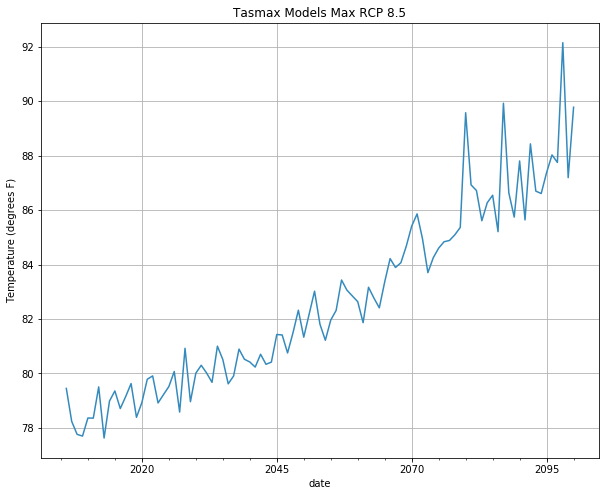

In [6]:
dfA['value'].plot(figsize=(10, 8), color='#348ABD')
plt.title("Tasmax Models Max RCP 8.5")
plt.ylabel("Temperature (degrees F)")
plt.grid(True)

### Histogram

Text(0.5,0,'Temperature (degrees F)')

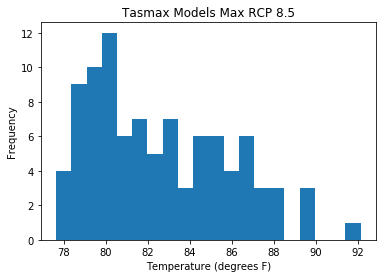

In [7]:
dfA['value'].plot.hist(bins=20)
plt.title("Tasmax Models Max RCP 8.5")
plt.xlabel("Temperature (degrees F)")

## Get daily timeseries

In [8]:
def celsius_to_F(val):
    return val * 9/5 + 32

def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

def process_daily_data(url, params):
    # Make request
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', url)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'C':
            df.value = df.value.apply(lambda x: celsius_to_F(x))
        elif units == 'K':
            df.value = df.value.apply(lambda x: kelvin_to_F(x))
        else:
            pass

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [9]:
daily_url = 'http://api.cal-adapt.org/api/series/tasmax_daily_loca_models-max_rcp85/rasters/'
# Variable to store data
dfD = process_daily_data(daily_url, params)

Processing: http://api.cal-adapt.org/api/series/tasmax_daily_loca_models-max_rcp85/rasters/


In [10]:
dfD.head()

,value
2006-01-01,62.333021
2006-01-02,62.039576
2006-01-03,64.102809
2006-01-04,64.992262
2006-01-05,62.109395


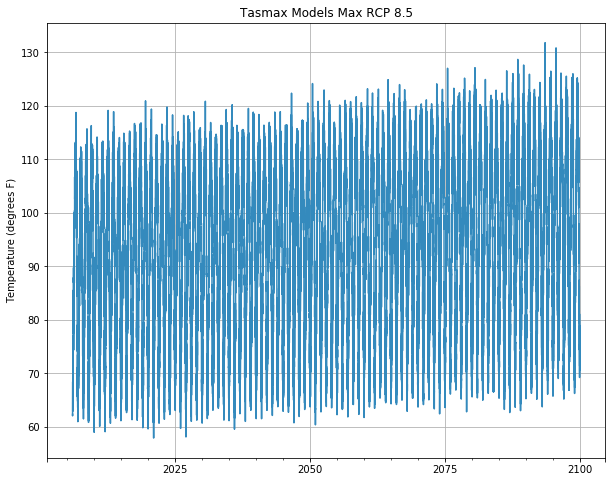

In [11]:
dfD['value'].plot(figsize=(10, 8), color='#348ABD')
plt.title("Tasmax Models Max RCP 8.5")
plt.ylabel("Temperature (degrees F)")
plt.grid(True)

Text(0.5,0,'Temperature (degrees F)')

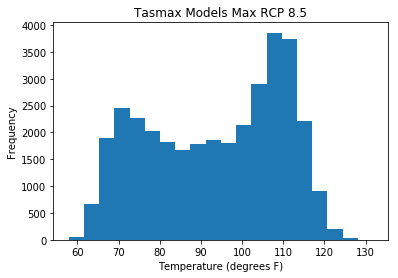

In [12]:
dfD['value'].plot.hist(bins=20)
plt.title("Tasmax Models Max RCP 8.5")
plt.xlabel("Temperature (degrees F)")

In [88]:
dfD.value.resample('1AS').mean()

2006-01-01    90.451999
2007-01-01    89.741678
2008-01-01    90.079510
2009-01-01    89.985211
2010-01-01    89.971310
2011-01-01    90.254684
2012-01-01    90.906394
2013-01-01    90.211511
2014-01-01    90.145938
2015-01-01    90.402345
2016-01-01    90.277500
2017-01-01    90.364797
2018-01-01    91.069013
2019-01-01    90.341342
2020-01-01    91.004416
2021-01-01    90.379363
2022-01-01    91.144430
2023-01-01    91.108362
2024-01-01    90.620318
2025-01-01    91.575364
2026-01-01    91.052291
2027-01-01    90.895038
2028-01-01    91.077566
2029-01-01    91.519655
2030-01-01    91.696038
2031-01-01    91.027849
2032-01-01    91.588518
2033-01-01    91.869166
2034-01-01    92.039050
2035-01-01    91.934373
                ...    
2070-01-01    95.802996
2071-01-01    95.319306
2072-01-01    95.428675
2073-01-01    95.430234
2074-01-01    95.689539
2075-01-01    95.619770
2076-01-01    96.060194
2077-01-01    96.249668
2078-01-01    96.463296
2079-01-01    95.789420
2080-01-01    96